In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

cal_image_paths = glob.glob('camera_cal/*.jpg')

In [2]:
def calibrate_camera(file_paths, x = 9, y = 6):
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    out_images = []
    org_images = []

    # Step through the list and search for chessboard corners
    for path in file_paths:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (x, y), corners, ret)
            org_images.append(cv2.imread(path))
            out_images.append(img)
        else:
            print('Failed for image: {}'.format(path))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist, out_images, org_images

In [23]:
def plot(row, col, images, figsize = (20,20)):
    fig = plt.figure(figsize = figsize)
    for i in range(row*col):
        img = images[i]
        plt.subplot(row, col, i + 1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('on')
    plt.show()

In [93]:
def gen_display_mtx(images,process_images):
    return [pic for t in zip(images,process_images) for pic in t]

In [4]:
mtx, dist, caled_images, org_images = calibrate_camera(cal_image_paths)

Failed for image: camera_cal/calibration1.jpg
Failed for image: camera_cal/calibration4.jpg
Failed for image: camera_cal/calibration5.jpg


In [5]:
undistorted_img = [cv2.undistort(img, mtx, dist, None, mtx) for img in org_images]

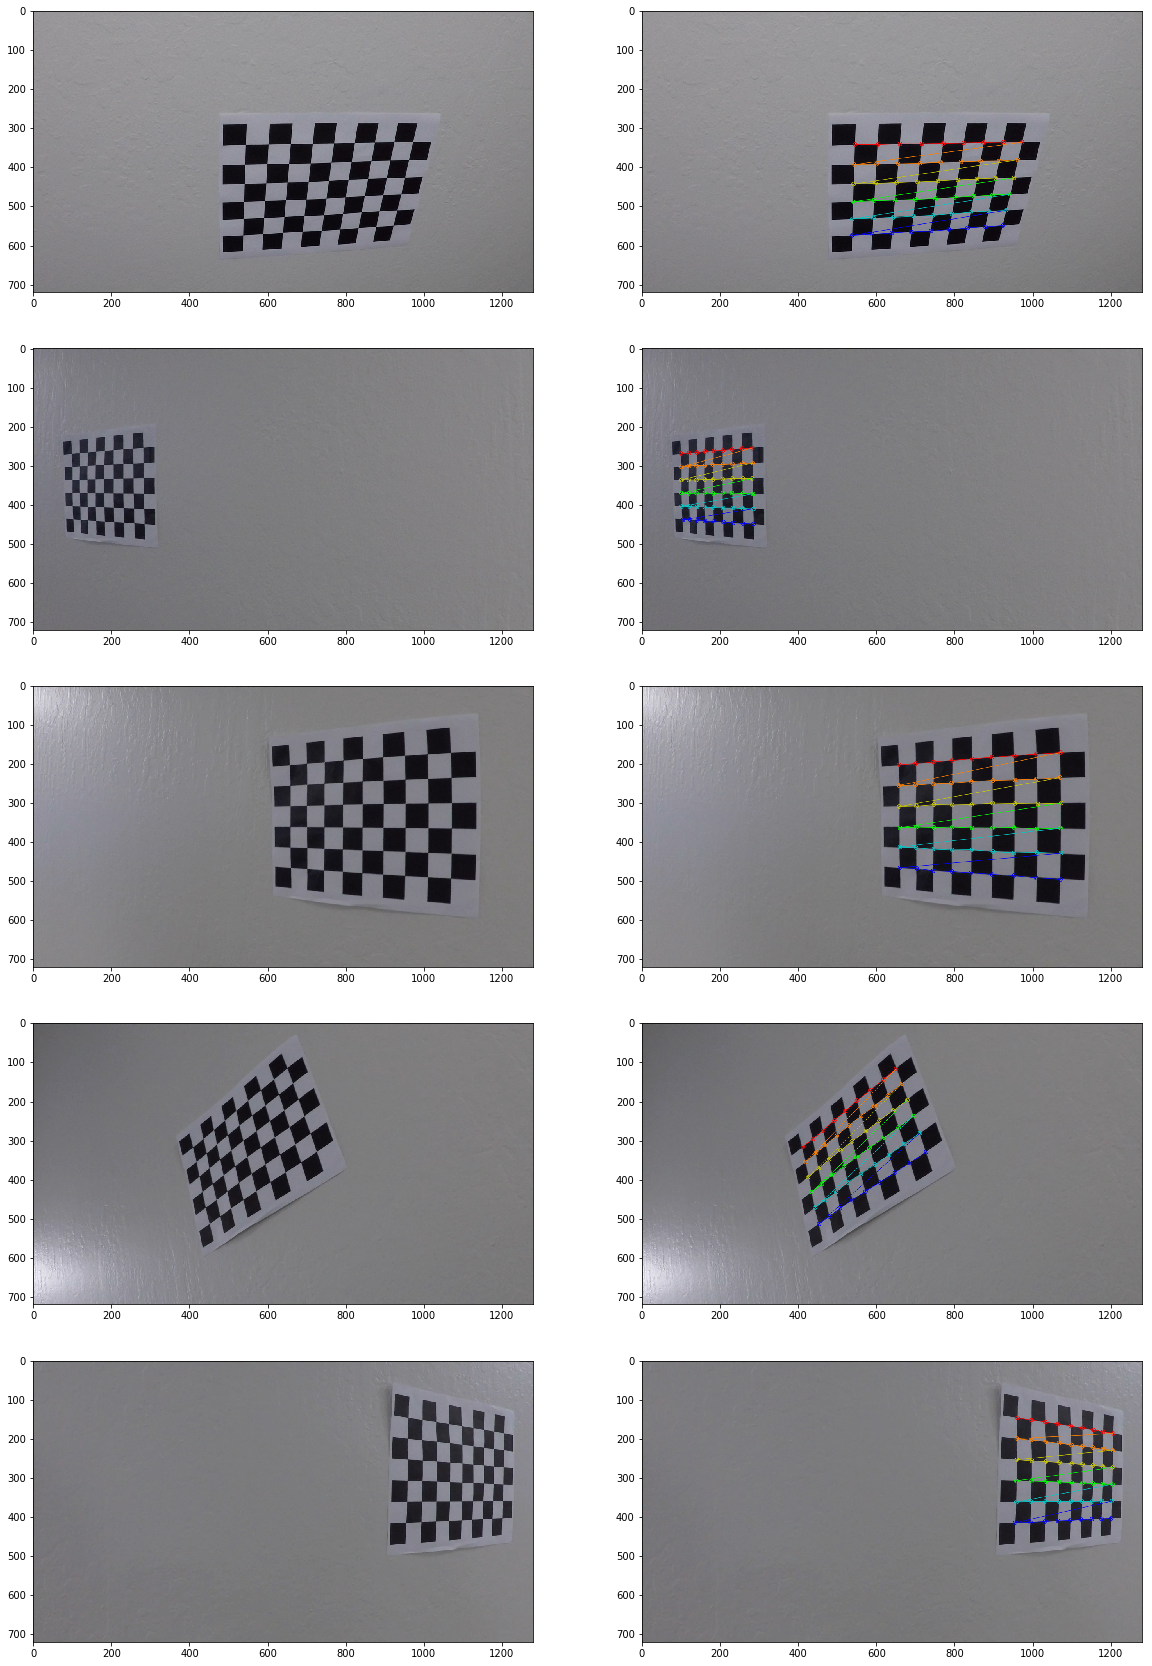

In [94]:
corner_mtx = gen_display_mtx(org_images,caled_images)
plot(5,2,corner_mtx[:10],figsize = (20,30))

In [7]:
def sample_undistorted(paths,mtx,dist):
    out_lst = []
    out_mtx = []
    for path in paths:
        img = cv2.imread(path)
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        out_mtx.append(img)
        out_mtx.append(undistorted)
        out_lst.append(undistorted)
    return out_lst,out_mtx
    

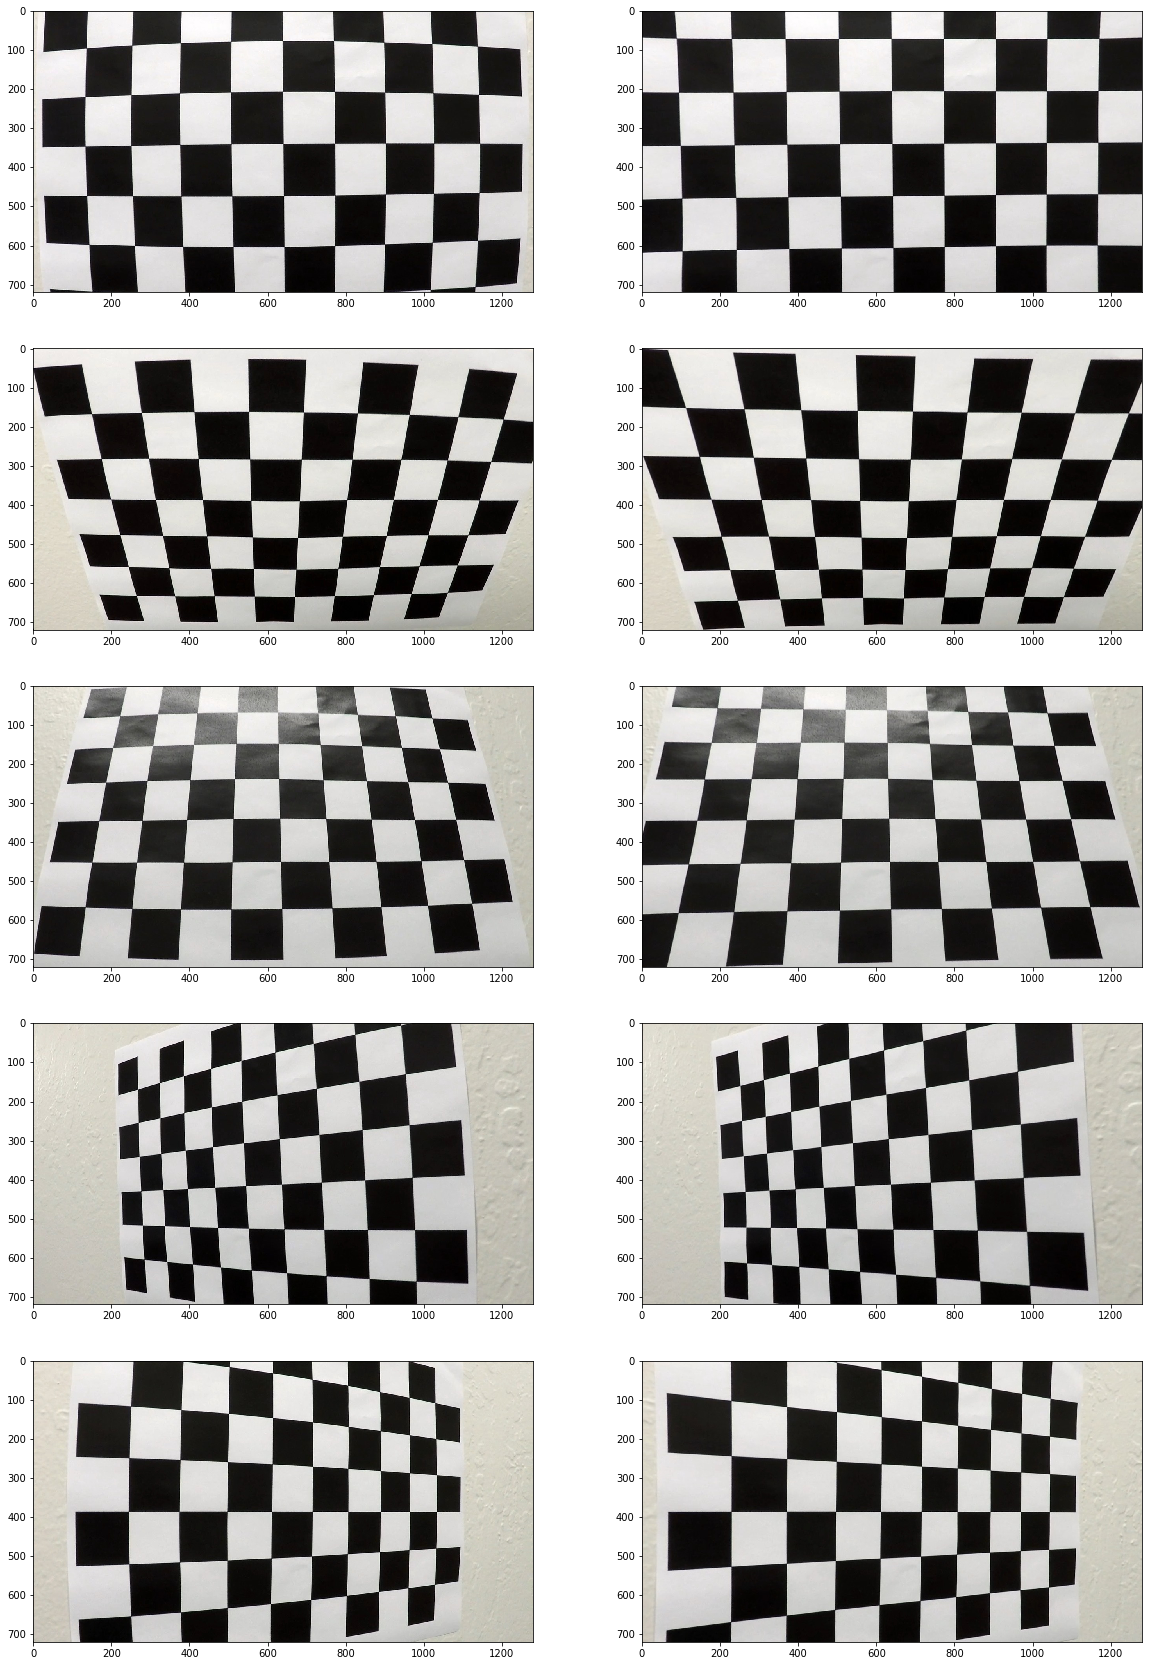

In [8]:
display_path = ['camera_cal/calibration{}.jpg'.format(i) for i in range(1,6)]
undistorted_lst,undistorted_mtx = sample_undistorted(display_path,mtx,dist)
plot(5,2,undistorted_mtx,figsize = (20,30))

In [191]:
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [cv2.imread(path) for path in test_image_paths]
undistorted_lst,undistorted_mtx = sample_distorted(test_image_paths,mtx,dist)


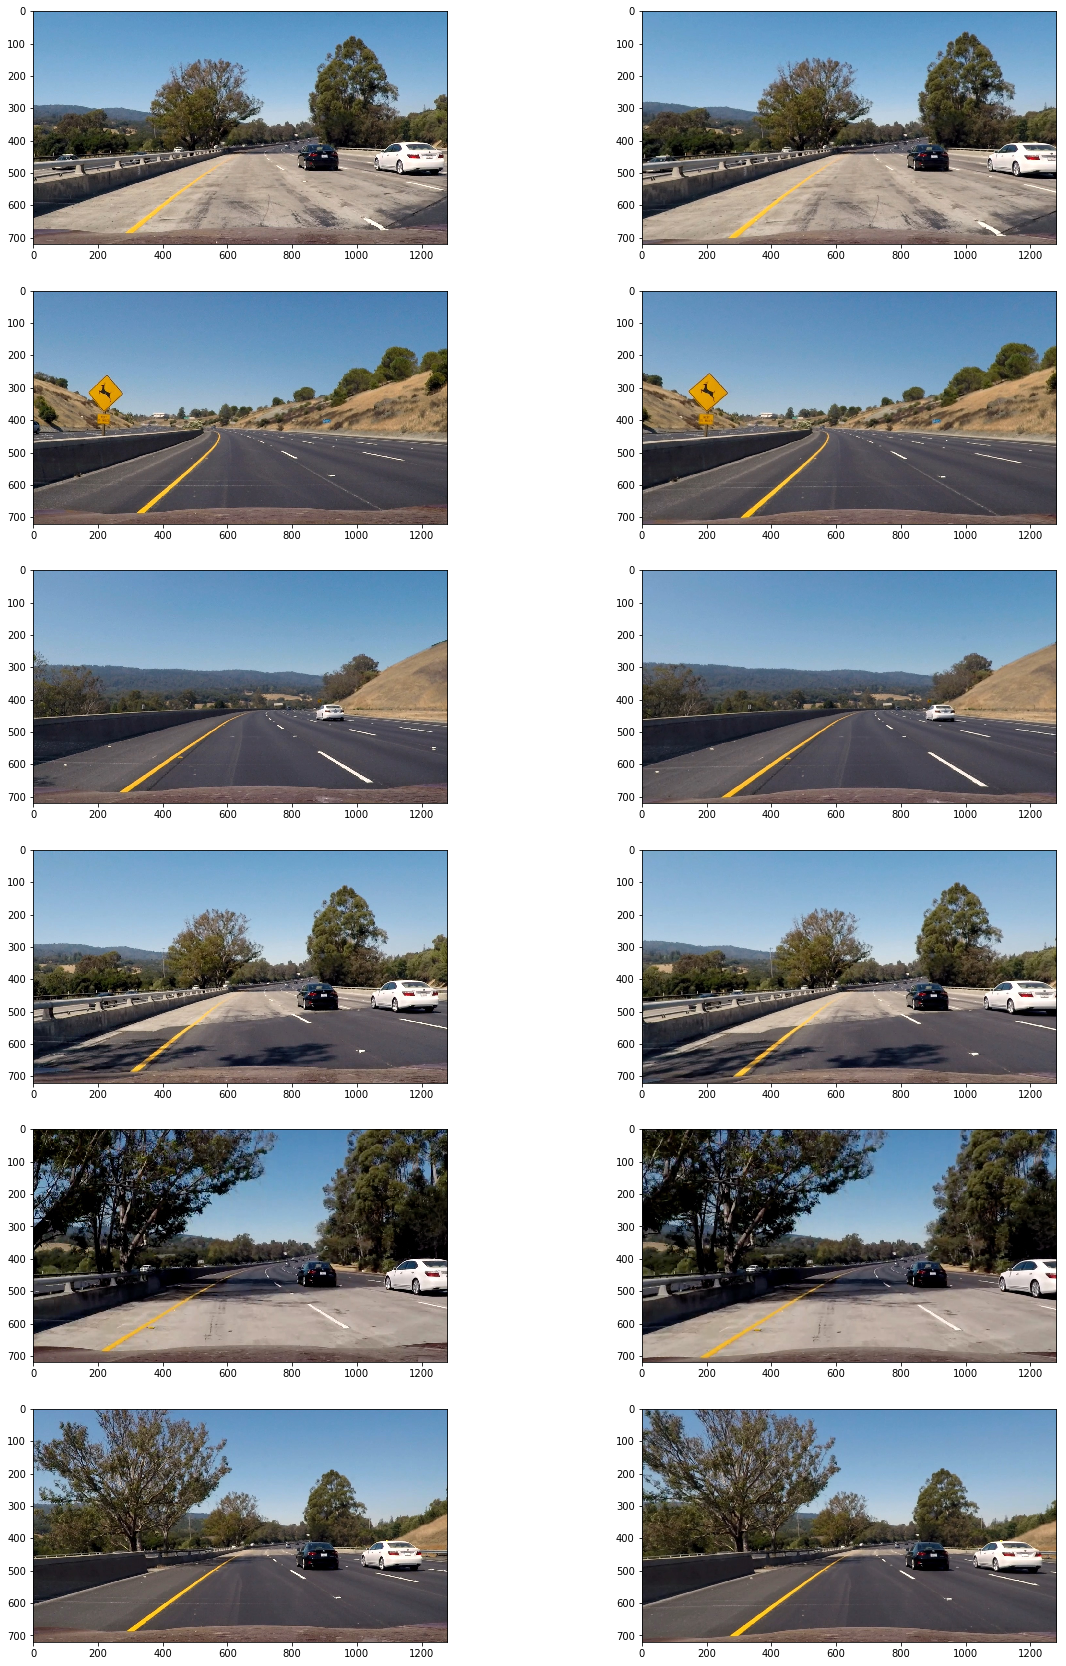

In [10]:
plot(len(test_image_paths),2,undistorted_mtx,figsize = (20,30))

In [40]:
def abs_sobel_thresh(img, sobel_kernel=3,orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def hls_s_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_h_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output
    
def combined_thresh(img,ksize=3):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(40, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = hls_s_thresh(img, thresh=(90, 255))
    h_binary = hls_h_thresh(img, thresh=(15, 100))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))|((s_binary == 1) & (h_binary == 1))] = 1
    return combined

In [95]:
thresh_img = [combined_thresh(img) for img in undistorted_lst]
thresh_mtx = gen_display_mtx(undistorted_lst,thresh_img)

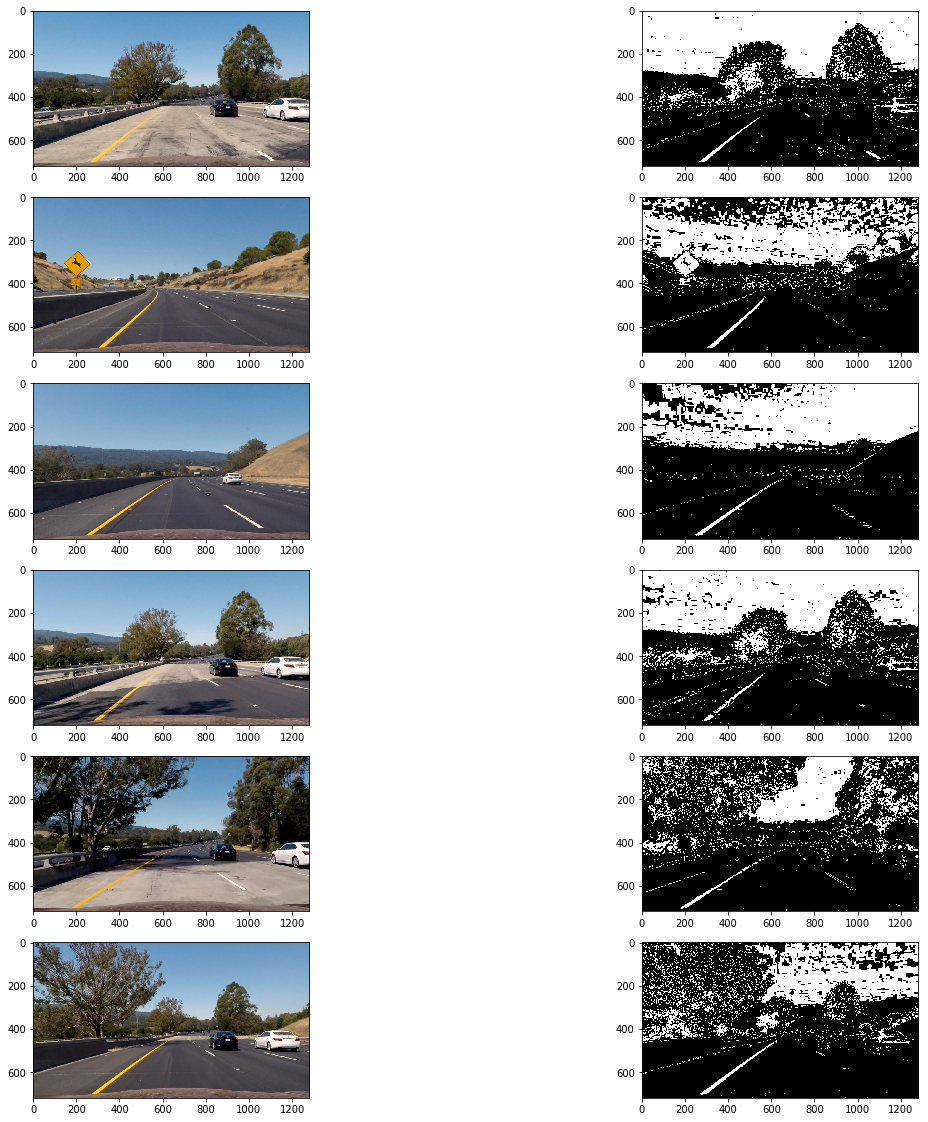

In [43]:
plot(6,2,thresh_mtx,figsize = (20,20))

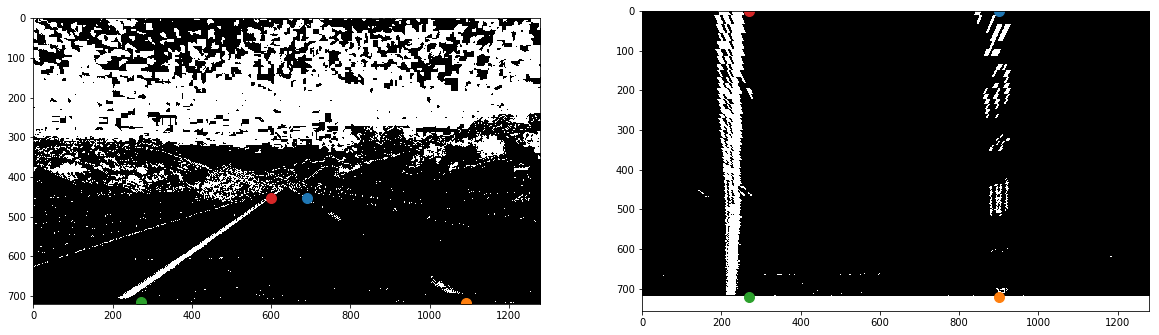

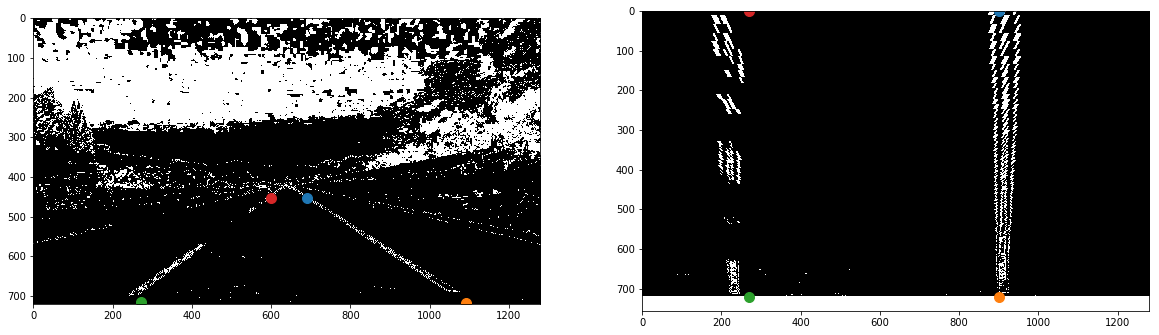

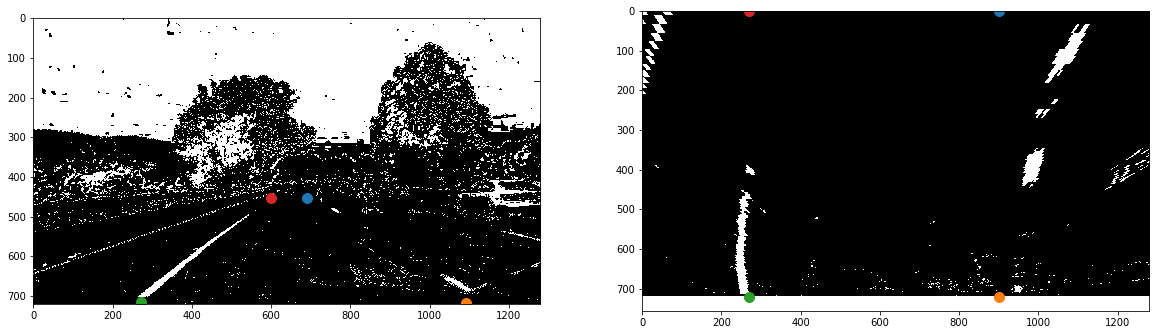

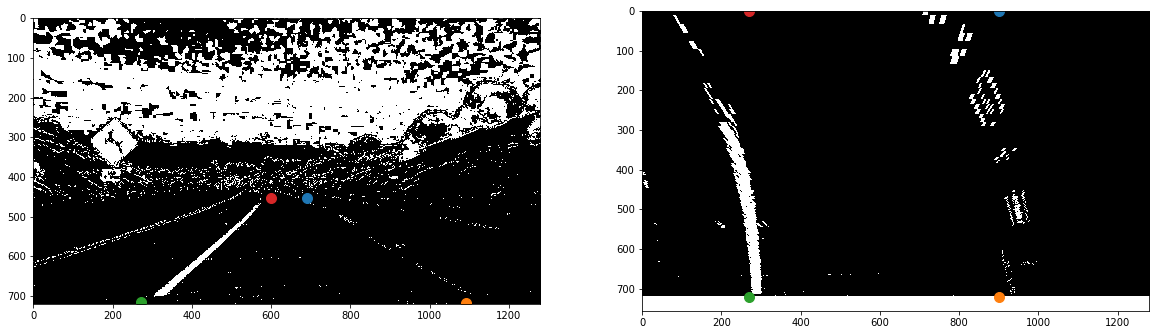

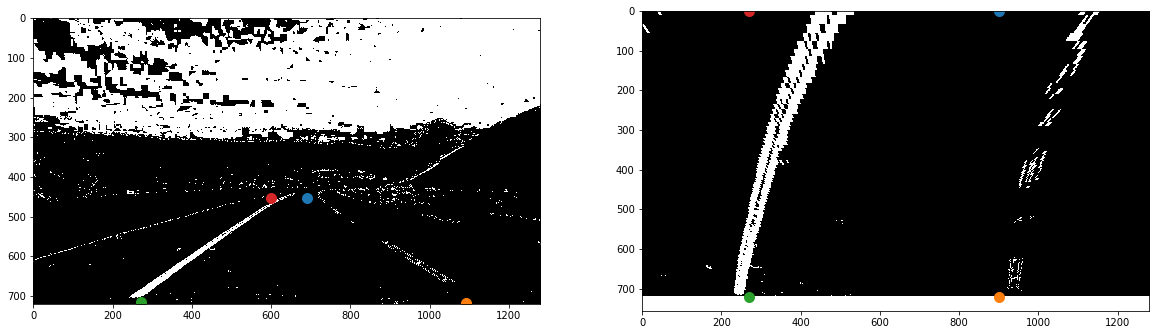

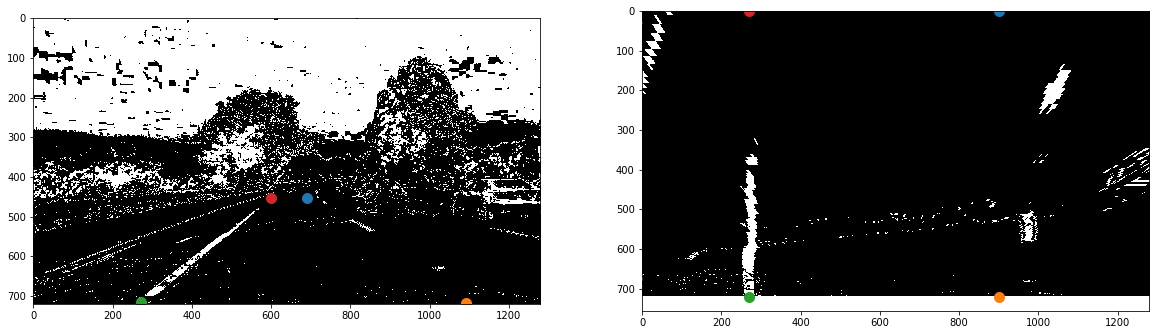

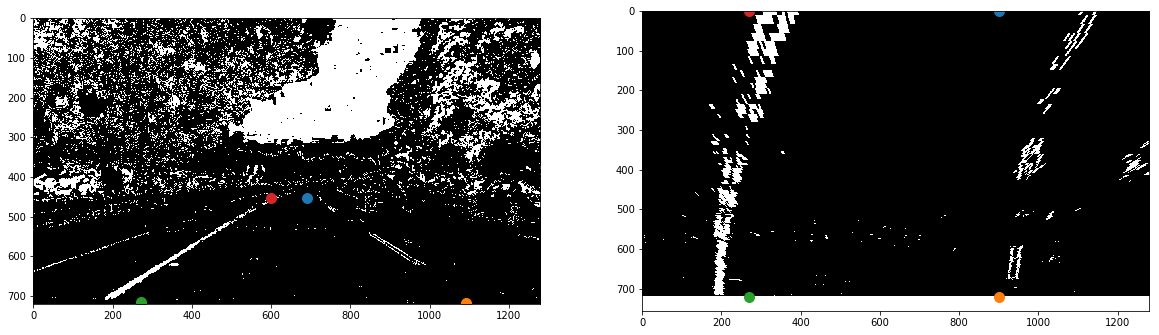

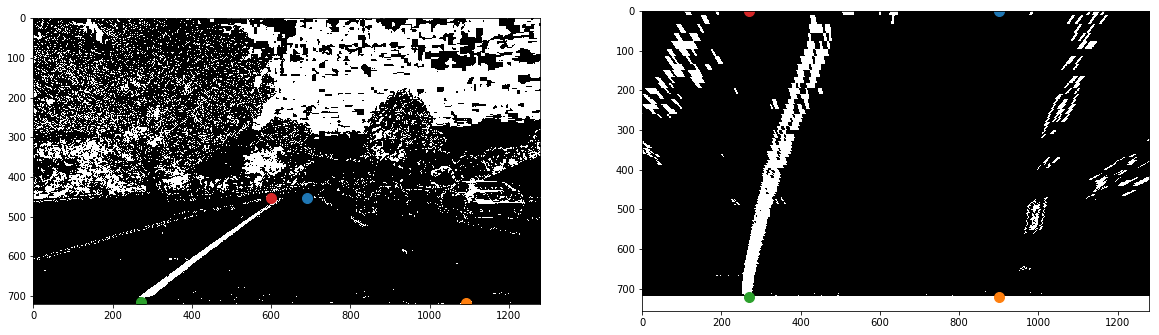

In [53]:
src = np.float32([(690,452),(1093,718),(272,716),(600,452)])
dst = np.float32([(900,0),(900,720),(270,720),(270,0)])
def warper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

def plot_src_dst(img,src,dst):
    plt.figure(figsize = (20,20))
    warped = warper(img,src,dst)
    plt.subplot(1,2,1)
    plt.imshow(img,cmap = 'gray')
    for x,y in src:
        plt.plot(x,y,'.',markersize=20)
    
    plt.subplot(1,2,2)
    plt.imshow(warped,cmap = 'gray')

    for x,y in dst:
        plt.plot(x,y,'.',markersize=20)    

straight_line_paths = glob.glob('test_images/straight_lines*.jpg')
straight_line_images = [cv2.imread(path) for path in straight_line_paths]
threshed_s_line_images = [combined_thresh(cv2.undistort(img, mtx, dist, None, mtx)) for img in straight_line_images]

for img in threshed_s_line_images + thresh_img:
    plot_src_dst(img,src,dst)

In [162]:
def show_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.figure()
    plt.plot(histogram)
    
def fit_poly(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx,right_fitx

def draw_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [187]:
def find_curvature(binary_warped,left_fit,right_fit,leftx,rightx):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_centre = binary_warped.shape[1]/2
    lane_centre = (leftx[::-1][0] + rightx[::-1][0]) / 2

    centre = (car_centre - lane_centre) * xm_per_pix
    
    return left_curverad, right_curverad,centre

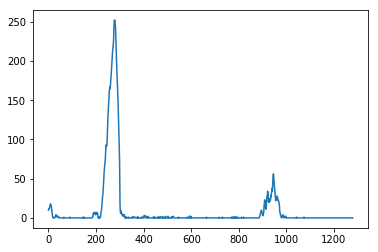

In [184]:
warped_test_images = [warper(img,src,dst) for img in thresh_img]
show_histogram(warped_test_images[1])

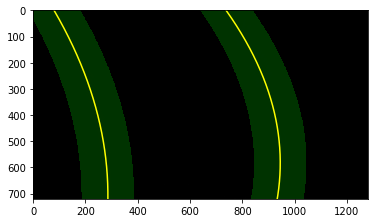

In [185]:
draw_lines(warped_test_images[1])

In [209]:
left_fit,right_fit,leftx,rightx= fit_poly(warped_test_images[1])
curve_left,curve_right,centre_dist = find_curvature(warped_test_images[1],left_fit,right_fit,leftx,rightx)

In [220]:
def draw_green_box(image, warped, leftx,rightx):
    img = np.copy(image)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    invM = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(color_warp, invM, (warped.shape[1],warped.shape[0]))
    result = cv2.addWeighted(img, 1, unwarped, 0.5, 0)
    return result

def put_on_text(image,curvature,centre_dist):
    curve_text = "Curve Radius: {:.3f}m".format(curvature)
    centre_text = "Car in centre"
    if centre_dist > 0:
        centre_text = "{:.3f}m to the right".format(centre_dist)
    if centre_dist < 0:
        centre_text = "{:.3f}m to the left".format(-centre_dist)
        
    cv2.putText(image,curve_text, (100,100),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2,cv2.LINE_AA)
    cv2.putText(image,centre_text, (100,200),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2,cv2.LINE_AA)
    return image


In [221]:
green_box = draw_green_box(test_images[1],warped_test_images[1],leftx,rightx)
final = put_on_text(green_box,(curve_left+curve_right)/2, centre_dist)

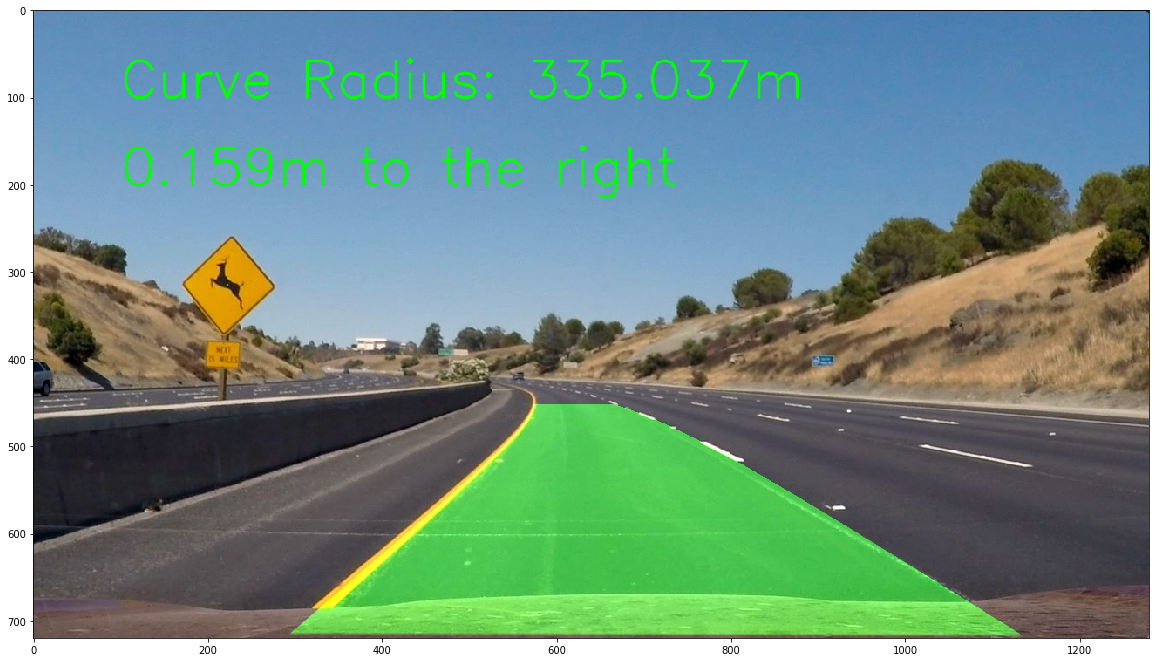

In [223]:
plot(1,1,[final])

In [224]:
def process_image(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    threshed = combined_thresh(undistorted)
    warped = warper(threshed,src,dst)
    left_fit,right_fit,leftx,rightx= fit_poly(warped)
    curve_left,curve_right,centre_dist = find_curvature(warped,left_fit,right_fit,leftx,rightx)
    green_boxed = draw_green_box(image,warped,leftx,rightx)
    complete = put_on_text(green_boxed,(curve_left+curve_right)/2, centre_dist)
    return complete

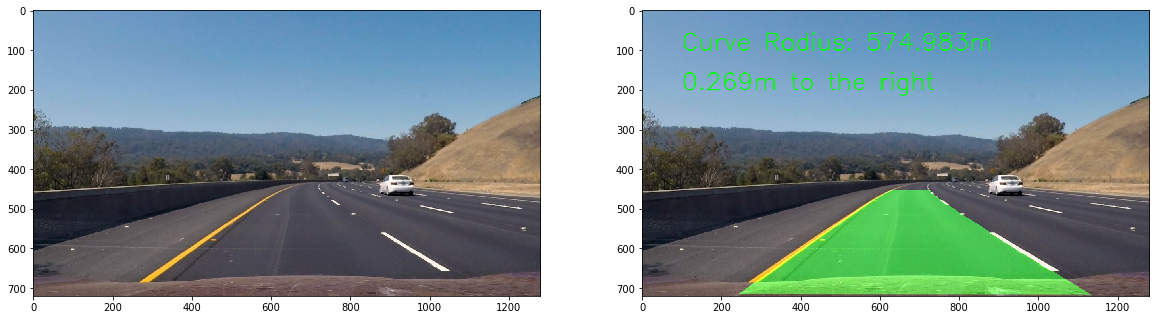

In [226]:
processed_image = process_image(test_images[2])
plot(1,2,[test_images[2], processed_image])

In [228]:
from moviepy.editor import VideoFileClip
video_out_path = "output_images/project_video_out.mp4"
video_in = VideoFileClip('project_video.mp4')
video_out = video_in.fl_image(process_image)
%time video_out.write_videofile(video_out_path, audio=False)

[MoviePy] >>>> Building video output_images/project_video_out.mp4
[MoviePy] Writing video output_images/project_video_out.mp4


100%|█████████▉| 1260/1261 [08:36<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out.mp4 

CPU times: user 7min 29s, sys: 2min 19s, total: 9min 48s
Wall time: 8min 38s


In [230]:
video_out_path2 = "output_images/challenge_out.mp4"
video_in2 = VideoFileClip('challenge_video.mp4')
video_out2 = video_in2.fl_image(process_image)
%time video_out2.write_videofile(video_out_path2, audio=False)

[MoviePy] >>>> Building video output_images/challenge_out.mp4
[MoviePy] Writing video output_images/challenge_out.mp4


100%|██████████| 485/485 [03:18<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_out.mp4 

CPU times: user 2min 52s, sys: 52.2 s, total: 3min 44s
Wall time: 3min 19s


In [ ]:
#https://discussions.udacity.com/t/unable-to-draw-green-surface-on-the-lane/247752